# Anomaly Review

During the process of generating coordinates for the ASL translator, it was discovered that not all images sent to Google MediaPipe provided a list of usable coordinates. In fact, the results returned by MediaPipe were skewed resulting in some characters having more observations than others. Consequently, actions were subsequently taken to balance the data across all characters to train the model.

This notebook was created to review those anomalies and investigate why some images did not create usable results.

## Retrieve the files from Kaggle

To retrieve the file from Kaggle, we can use curl. The code below demonstrates how we can download the files directly from Kaggle and unzip it ino a data directoy in the content folder.

In [6]:
# Download the ASL alphabet
! curl -L -o /content/archive.zip https://www.kaggle.com/api/v1/datasets/download/grassknoted/asl-alphabet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1049M  100 1049M    0     0  78.6M      0  0:00:13  0:00:13 --:--:--  140M


In [7]:
# unzip the archive file
! unzip -q /content/archive.zip -d /content/data

## Setup the environment for processing the image data

In [8]:
# let's install mediapipe
! pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 17.8 MB/s eta 0:00:00


In [9]:
import os

import mediapipe as mp # install mediapipe
import cv2 # install OpenCV library
import matplotlib.pyplot as plt
#from google.colab import drive

import csv
import copy
import argparse
import itertools

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Let's set up some constants we will be using from hear on out
data_dir = '/content/data'
csv_path = '/content/drive/MyDrive/landmarks_anomaly_v1.csv'

In [23]:
# import the hands mediapipe model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.35)

In [18]:
# Define the function to get the landmarks
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # We will not be using the z coordinate for our project.
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [19]:
# Preprocessing of landmarks. Basically normalization, min-max
# My min max normalization
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    aux_x = []
    aux_y = []

    # Convert to relative coordinates
    for landmark_point in temp_landmark_list:
        current_x, current_y = landmark_point[0], landmark_point[1]
        aux_x.append(current_x)
        aux_y.append(current_y)


    min_x, min_y = min(aux_x), min(aux_y)
    max_x, max_y = max(aux_x), max(aux_y)

    def normalize_(n, min_value, max_value):
        return (n - min_value) / (max_value - min_value)

    x_normalized = list(map(lambda x: normalize_(x, min_x, max_x), aux_x))
    y_normalized = list(map(lambda x: normalize_(x, min_y, max_y), aux_y))

    #print(x_normalized)
    #print(y_normalized)
    final_list = [cor for pair in zip(x_normalized, y_normalized) for cor in pair]

    return final_list

In [20]:
def logging_csv(label, landmark_list,csv_path, img_path):
    with open(csv_path, 'a', newline="") as f:
        writer = csv.writer(f)
        writer.writerow([ *landmark_list, label, img_path])
    return


## Generate the CSV file

In [25]:
# only run this once because this creates a new row with headers
header = [
    "1_X", "1_Y", "2_X", "2_Y", "3_X", "3_Y", "4_X", "4_Y", "5_X", "5_Y",
    "6_X", "6_Y", "7_X", "7_Y", "8_X", "8_Y", "9_X", "9_Y", "10_X", "10_Y",
    "11_X", "11_Y", "12_X", "12_Y", "13_X", "13_Y", "14_X", "14_Y", "15_X", "15_Y",
    "16_X", "16_Y", "17_X", "17_Y", "18_X", "18_Y", "19_X", "19_Y", "20_X", "20_Y",
    "21_X", "21_Y", "Label", 'Filename'
]

with open(csv_path, 'a', newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)



In [26]:
# ---- now with the good part ----


# for img_path in os.listdir(os.path.join(data_dir, dir_)): # open the data directory
for root, dirs, files in os.walk(data_dir):
  for img_path in files:
    # print(len(files))
    # break
    label = img_path[0]
    # print(img_path, label)
    # raise SystemExit()
    img = cv2.imread(os.path.join(root, img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    result = hands.process(img_rgb) # get landmarks

    if result.multi_hand_landmarks:
      for hand_landmarks in result.multi_hand_landmarks:

        landmark_list = calc_landmark_list(img_rgb, hand_landmarks)
        # print(landmark_list)

        pre_processed_landmark = pre_process_landmark(landmark_list) # preprocess landmarks
        # print(pre_processed_landmark)

        logging_csv(label, pre_processed_landmark, csv_path, img_path) # write a csv

# Data exploration and Examination

In [27]:
import pandas as pd

In [29]:
df = pd.read_csv(csv_path)
df.head()

,1_X,1_Y,2_X,2_Y,3_X,3_Y,4_X,4_Y,5_X,5_Y,...,18_X,18_Y,19_X,19_Y,20_X,20_Y,21_X,21_Y,Label,Filename
0,1.0,0.225000,0.886792,0.387500,0.698113,0.587500,0.566038,0.825000,0.433962,1.0,...,0.424528,0.100000,0.273585,0.250000,0.339623,0.325000,0.424528,0.325000,Q,Q1881.jpg
1,1.0,0.562500,0.898305,0.562500,0.661017,0.625000,0.406780,0.833333,0.220339,1.0,...,0.372881,0.375000,0.152542,0.500000,0.152542,0.541667,0.203390,0.562500,Q,Q1717.jpg
2,1.0,0.517857,0.903226,0.678571,0.731183,0.821429,0.537634,0.910714,0.387097,1.0,...,0.645161,0.017857,0.440860,0.017857,0.279570,0.125000,0.161290,0.250000,Q,Q1508.jpg
3,1.0,0.320000,0.882353,0.440000,0.694118,0.600000,0.529412,0.820000,0.388235,1.0,...,0.482353,0.200000,0.317647,0.320000,0.329412,0.400000,0.388235,0.420000,Q,Q1854.jpg
4,1.0,0.232558,0.948276,0.418605,0.793103,0.616279,0.646552,0.825581,0.525862,1.0,...,0.474138,0.081395,0.318966,0.220930,0.370690,0.290698,0.448276,0.290698,Q,Q1898.jpg


<Axes: xlabel='Label'>

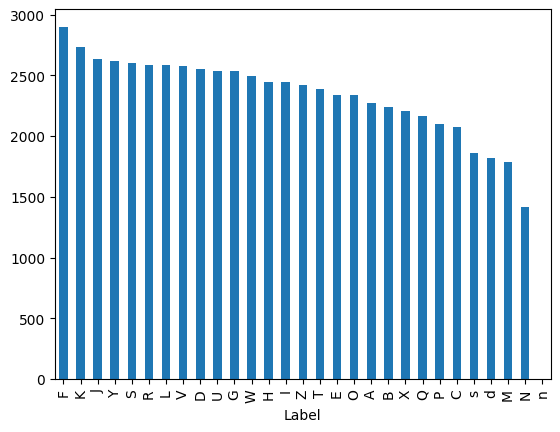

In [35]:
# Let's do a value count to get a feel for the numbe of different letters
df['Label'].value_counts().plot.bar()

There should be 3000 observations per gesture. The letter F appears to have the smallest amount of anomalies. Let's get a list of files for Letter F and compare them to those which we successfully processed with Google MediaPipe and display those which could not be processed.

In [56]:
# Let's get a list of files specifically from the F directory
F_dir = data_dir + '/asl_alphabet_train/asl_alphabet_train/F/'

# Check if the directory exists
if not os.path.exists(F_dir):
    raise ValueError(f"Directory {F_dir} does not exist!")

files = [ f for f in os.listdir(F_dir)]

In [57]:
print(files)



['F2661.jpg', 'F435.jpg', 'F2187.jpg', 'F2688.jpg', 'F137.jpg', 'F129.jpg', 'F649.jpg', 'F211.jpg', 'F2490.jpg', 'F1907.jpg', 'F249.jpg', 'F1915.jpg', 'F2919.jpg', 'F284.jpg', 'F2945.jpg', 'F31.jpg', 'F1103.jpg', 'F1308.jpg', 'F297.jpg', 'F1305.jpg', 'F2323.jpg', 'F654.jpg', 'F2234.jpg', 'F2109.jpg', 'F1142.jpg', 'F1510.jpg', 'F1074.jpg', 'F2215.jpg', 'F2148.jpg', 'F2105.jpg', 'F51.jpg', 'F2445.jpg', 'F2025.jpg', 'F2008.jpg', 'F319.jpg', 'F43.jpg', 'F2227.jpg', 'F124.jpg', 'F1477.jpg', 'F2573.jpg', 'F437.jpg', 'F478.jpg', 'F871.jpg', 'F1813.jpg', 'F2501.jpg', 'F1349.jpg', 'F2703.jpg', 'F758.jpg', 'F1514.jpg', 'F171.jpg', 'F514.jpg', 'F874.jpg', 'F1057.jpg', 'F593.jpg', 'F181.jpg', 'F1285.jpg', 'F659.jpg', 'F476.jpg', 'F221.jpg', 'F2659.jpg', 'F1592.jpg', 'F2342.jpg', 'F122.jpg', 'F2020.jpg', 'F1628.jpg', 'F2556.jpg', 'F1594.jpg', 'F951.jpg', 'F2538.jpg', 'F1690.jpg', 'F2073.jpg', 'F10.jpg', 'F678.jpg', 'F2235.jpg', 'F535.jpg', 'F2440.jpg', 'F1444.jpg', 'F2302.jpg', 'F2717.jpg', 'F361.j

In [52]:
!pwd

/content


In [58]:
F_df = df[df['Label'] == 'F']

In [59]:
processed_files = F_df['Filename'].to_list()

In [60]:
unprocessed_files = [filename  for filename in files if filename not in processed_files ]

['F211.jpg',
 'F181.jpg',
 'F221.jpg',
 'F2003.jpg',
 'F840.jpg',
 'F947.jpg',
 'F2051.jpg',
 'F1172.jpg',
 'F230.jpg',
 'F215.jpg',
 'F218.jpg',
 'F2001.jpg',
 'F224.jpg',
 'F2002.jpg',
 'F194.jpg',
 'F229.jpg',
 'F2162.jpg',
 'F292.jpg',
 'F2164.jpg',
 'F174.jpg',
 'F2171.jpg',
 'F833.jpg',
 'F2004.jpg',
 'F632.jpg',
 'F187.jpg',
 'F427.jpg',
 'F2610.jpg',
 'F228.jpg',
 'F2159.jpg',
 'F225.jpg',
 'F175.jpg',
 'F2161.jpg',
 'F949.jpg',
 'F214.jpg',
 'F186.jpg',
 'F943.jpg',
 'F2413.jpg',
 'F216.jpg',
 'F222.jpg',
 'F2052.jpg',
 'F1178.jpg',
 'F2406.jpg',
 'F179.jpg',
 'F334.jpg',
 'F636.jpg',
 'F191.jpg',
 'F836.jpg',
 'F839.jpg',
 'F206.jpg',
 'F193.jpg',
 'F2138.jpg',
 'F2165.jpg',
 'F945.jpg',
 'F1558.jpg',
 'F205.jpg',
 'F182.jpg',
 'F227.jpg',
 'F226.jpg',
 'F177.jpg',
 'F333.jpg',
 'F1175.jpg',
 'F2173.jpg',
 'F634.jpg',
 'F961.jpg',
 'F212.jpg',
 'F2163.jpg',
 'F190.jpg',
 'F173.jpg',
 'F952.jpg',
 'F2170.jpg',
 'F189.jpg',
 'F948.jpg',
 'F223.jpg',
 'F180.jpg',
 'F197.jpg',
 '

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

F2661.jpg


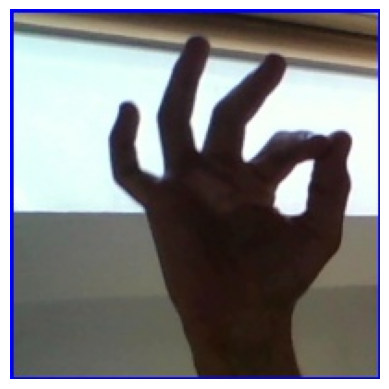

F435.jpg


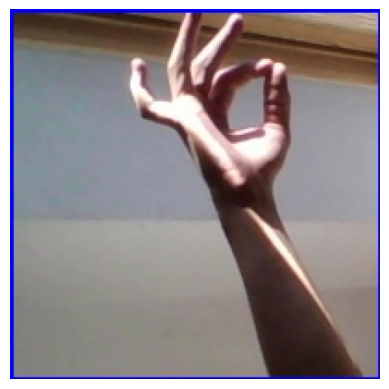

F2187.jpg


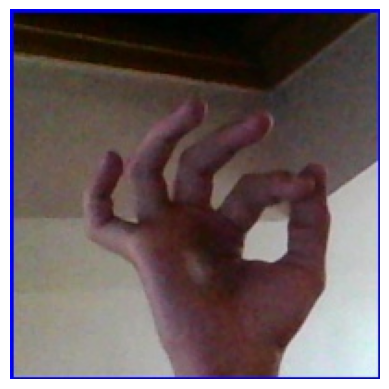

F2688.jpg


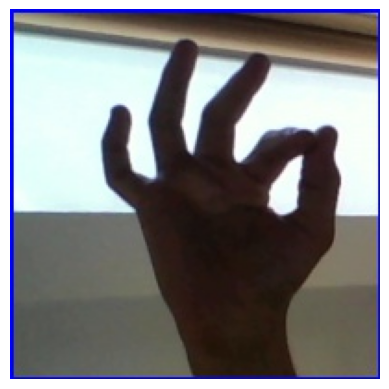

F137.jpg


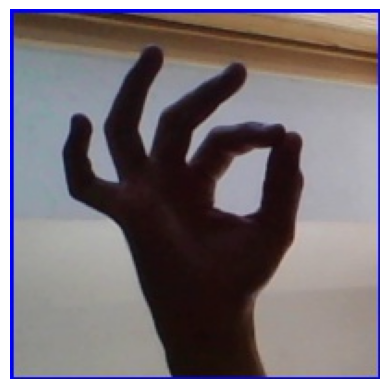

In [66]:
# Let's have a look at 5 good images
for img in processed_files[:5]:
  processed_img = mpimg.imread(F_dir+ '/'+ img) #Replace "image.jpg" with the path of your image
  print(img)
  plt.imshow(processed_img)
  plt.axis('off')
  plt.show()

F211.jpg


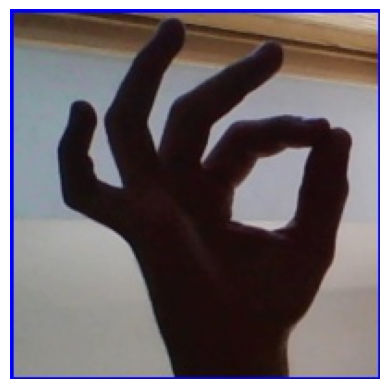

F181.jpg


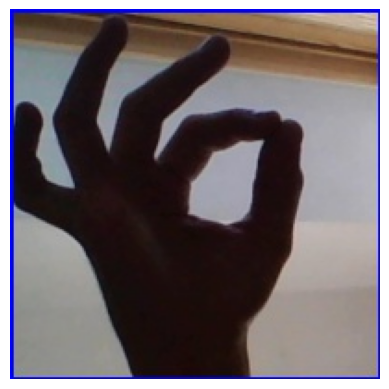

F221.jpg


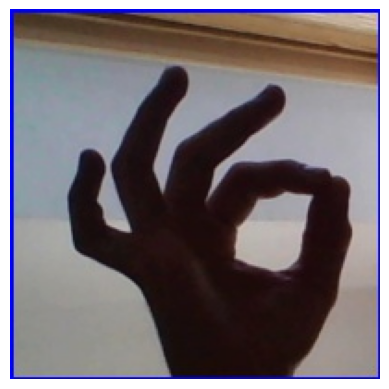

F2003.jpg


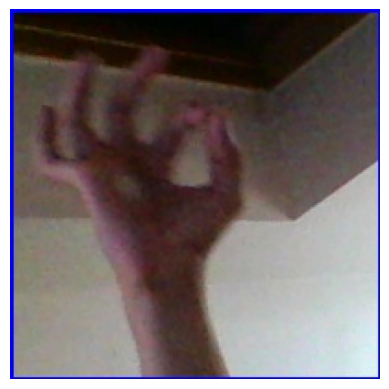

F840.jpg


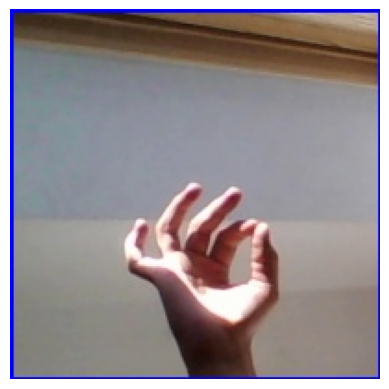

In [65]:
# Let's have a look at 5 bad images
for img in unprocessed_files[:5]:
  unprocessed_img = mpimg.imread(F_dir+ '/'+ img) #Replace "image.jpg" with the path of your image
  print(img)
  plt.imshow(unprocessed_img)
  plt.axis('off')
  plt.show()

Images detected in the processed and unprocessed list of images were manually uploaded to [Google's MdeiaPipe](https://mediapipe-studio.webapps.google.com/demo/hand_landmarker) for analysis

It was observed that google could not identify the image as a hand and thus could not apply the skeleton overlay to detect the landmarks. Further details on how the image could be better prepared was not provided.